In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

from tensorflow.python.keras.models import load_model

from utility import clean_data, plot_images

In [4]:
classes = ['angry','disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [6]:
train_data = clean_data('data/train.csv')
train = train_data.feature.reshape((-1, 48, 48, 1))/255
train_x = train[:-2000]
train_label = train_data.label[:-2000]
train_onehot = train_data.onehot[:-2000]
test_x = train[-2000:]
test_label = train_data.label[-2000:]
test_onehot = train_data.onehot[-2000:]

In [5]:
cnn = load_model('cnn2.h5')
dnn = load_model('dnn2.h5')

In [6]:
cnn_predict = cnn.predict(test_x)
cnn_cls = np.argmax(cnn_predict, axis=1)

In [7]:
dnn_predict = dnn.predict(test_x)
dnn_cls = np.argmax(dnn_predict, axis=1)

Confusion matrix, without normalization
[[135   3  32  32  36   8  60]
 [  3  10   1   1   1   2   6]
 [ 18   0 126  18  47  18  32]
 [  5   1   6 438  16  12  33]
 [ 28   0  36  39 149   4  71]
 [  7   1  19  25   6 166  13]
 [ 11   0  25  40  44   6 210]]


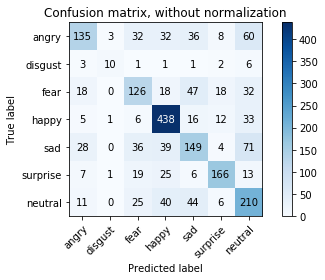

In [8]:
plot_confusion_matrix(test_label, cnn_cls, classes)

Confusion matrix, without normalization
[[155   2  33  22  79   1  14]
 [  8   6   5   0   4   1   0]
 [ 68   3  87  11  78   4   8]
 [121  25  52 184 114   1  14]
 [ 69   5  46  25 163   3  16]
 [ 83   2  42  11  33  60   6]
 [100   6  30  34 111   2  53]]


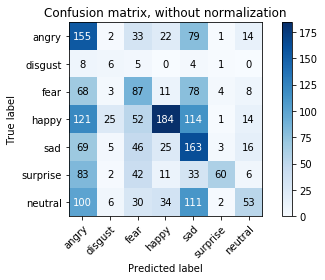

In [9]:
plot_confusion_matrix(test_label, dnn_cls, classes)

In [10]:
true_cls = pd.Series(test_label, name='true_cls')[test_label!=cnn_cls]
wrong_cls = pd.Series(cnn_cls, name='wrong_cls')[test_label!=cnn_cls]

In [11]:
wrong = pd.concat([true_cls, wrong_cls], axis = 1)

In [12]:
sad_neu = wrong[wrong['true_cls']==4][wrong['wrong_cls']==6].index.tolist()

/home/fengyuz/Documents/test/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [13]:
sample = sad_neu[0:9]

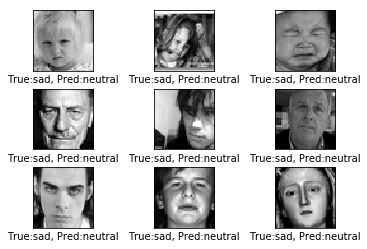

In [14]:
plot_images(test_x[sample], test_label[sample], cnn_cls[sample])

In [1]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations
from keras.models import load_model



Using TensorFlow backend.


In [2]:
cnn = load_model('cnn3.h5')

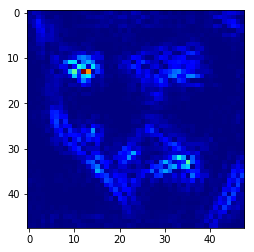

In [8]:
# Swap softmax with linear
cnn.layers[-1].activation = activations.linear
cnn = utils.apply_modifications(cnn)

grads = visualize_saliency(cnn, -1, filter_indices=test_label[0], seed_input=test_x[0], backprop_modifier='guided')
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')

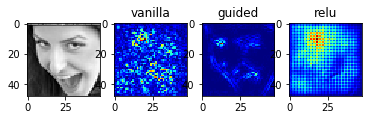

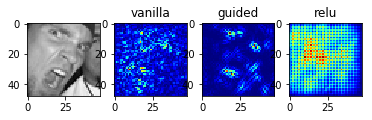

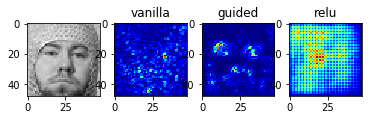

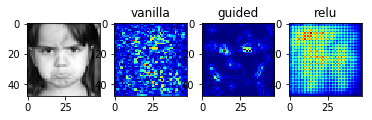

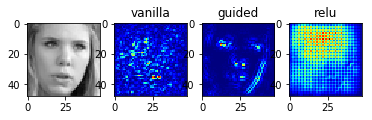

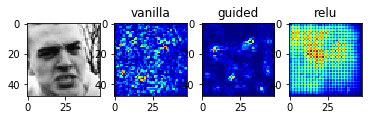

In [11]:
for idx in range(6):    
    

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(test_x[idx].reshape((48,48)), cmap='gray')
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_saliency(cnn, -1, filter_indices=test_label[idx], 
                                   seed_input=test_x[idx], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')